In [1]:
# Styling notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

### RSA key generation, encryption, decryption and attack via factorization

RSA keys are pairs of integers (n,e) and (n,d) - they're usually coded into one expression or stored alongside each other - here's a simple utility class that just stores one key with the component "first" and "second".

In [2]:
# Just a container with str function
class Key:
    def __init__(self, first, second):
        self.first = first
        self.second = second

    def __str__(self):
        return "Key [first: %d, second: %d]" % (self.first, self.second)

In [3]:
key = Key(111,-7) # Just a test, nothing to do with RSA
print(key)

Key [first: 111, second: -7]


### Main RSA mechanism  

**Create a Key Pair (public and private):**

1. Generate a pair of large, random distinct primes $p$ and $q$

2. Compute the modulus $n = p\times q$

3. Select an odd **public exponent** $e$ between 3 and $n-1$ that is relatively prime to $p-1$ and $q-1$ (65537 is usually chosen)

4. Compute the **private exponent** $d$ from $e, p$ and $q:$
   - Compute the [totient](Factorize.ipynb#totient) $\phi(n) = (p−1)\times (q−1)$
   - Solve the equation $e\times d \equiv 1 {\rm mod}\; \phi(n)$ for $d,$ i.e. compute $d$ as the 
[multiplicative inverse](Modular.ipynb#modinvert) of $e.$  
   

5. Output **(n,e) as the public key** and **(n,d) as the private key.**

6. To encrypt a message m, compute $m^e {\rm mod}\; n$
7. To decrypt a code c compute $c^d {\rm mod}\; n$



In [13]:
from Primes import sieve, randomPrime
from Modular import fastExpMod, modInverse
from math import gcd                        # the good one!
from Factorize import primeFactor

class KeyPair :

    # that's supposed to be a class variable
    Primes = sieve(50000)

    # initializer with some kind of hand-knit overloading
    #    takes two keys, if one or both not specified, just randomize the pair
    #    if both specified, just store them (that's in case I want special keys for testing)
    def __init__(self, public = None, private = None):
        if public is None or private is None :  # no parameters -->
            self.randomize()                    # just randomize the keys
        else :                                  # keys given -->
            self.public = public                # take those
            self._private = private
        
    # the toString() equivalent
    def __str__(self):
        return "KeyPair\n   public: %s\n   private: %s" % (self.public, self._private)

    def randomize(self):
        # Create a connected random key pair

        # 1. create two different random primes p and q

        # There are practical considerations for selecting these primes
        # a. not too close to the "edges" of the range
        #    too easy to brute-force bidirectionally
        # b. not too close together (close to the center of the range)
        #    too easy to brute-force radially

        # Here we chose to ignore all these considerations :-)

        p = randomPrime(KeyPair.Primes,2)       # don't want the 2
        q = randomPrime(KeyPair.Primes,2)       # ditto
        # Should be different!
        while (q == p) :                        # and here I would love to use a do-while, but alas...
            q = randomPrime(KeyPair.Primes)     # shouldn't dead loop, right?

        # 2. Modulus and totient
        n = p*q                                 # modulus
        phi = (p - 1)*(q - 1)                   # totient

        # 3. e must be relatively prime to phi
        #    else modInverse won't work
        e = 65537                               # usually a good guess
        while gcd(e,phi) != 1 :                 # just in case - never seen this loop run
            e += 2                              # since (p-1)*(q-1) is even, e better be odd

        # 4. d solves e^d = 1 (mod phi)
        d = modInverse(e,phi)

        # Got it
        self.public = Key(n,e)
        self._private = Key(n,d)

    # encryption (Who would've thought...)
    def encrypt(self,m) :
        return fastExpMod(m,self.public.second,self.public.first)

    # decryption (Why am I even writing these stupid comments??)
    def decrypt(self,c) :
        return fastExpMod(c,self._private.second,self._private.first)

In [33]:
pair = KeyPair()
print(pair)

KeyPair
   public: Key [first: 717661627, second: 65537]
   private: Key [first: 717661627, second: 525131545]


In [34]:
m = 1776
c = pair.encrypt(m)
print(c)

399655411


In [35]:
pair.decrypt(c)

1776

**Note that encrypt and decrypt are mirror images**  
So they can be used in any order

In [36]:
d = pair.decrypt(m)
print(d)
pair.encrypt(d)

404894522


1776

Ok! Why do encryption and decryption work like that? (Skip on first reading)  

**Euler-Fermat Theorem** (really tough, no proof)
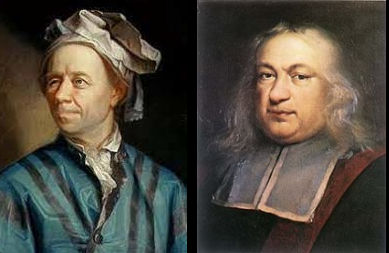

If a and n are relatively prime, then $a^{\phi(n)}\equiv 1 ({\rm mod}\; n)$

In [9]:
from Primes import sieve
from Factorize import eulerPhi

def eulerFermatDemo(a,n) :
    return fastExpMod(a,eulerPhi(n,KeyPair.Primes),n)

eulerFermatDemo(2048,12345)

1

**The important property of $e$ and $d:$** For any integer $m:\; m^{ed} \equiv m\; ({\rm mod}\; n)$ 

Note, that's all we really need to show both aspects of encyption and decryption (more in a moment).

1. We chose $d$ such that $ed \equiv 1\; ({\rm mod}\; \phi(n))$
1. That means $ed = k\phi(n) + 1,$ for an unknown integer $k.$
1. Now, according to Euler-Fermat: $m^{\phi(n)} \equiv 1\; ({\rm mod}\; n)$
1. That means $m^{k\phi(n)} = m^{\phi(n)} \times m^{\phi(n)} \times ... \times\; m^{\phi(n)} \equiv 1\; ({\rm mod}\; n),$ because all $k$ factors $m^{\phi(n)}$ are 1 mod $n.$
1. That means $m^{ed} = m^{k\phi(n)+1} = m\times m^{k\phi(n)}  \equiv m\; ({\rm mod}\; n)$ q.e.d.

Now define encryption as $e(m) = m^e\, {\rm mod}\; n$ and decryption as $d(c) = c^d\, {\rm mod}\; n.$

$d(e(m)) = (m^e\, {\rm mod}\; n)^d\; {\rm mod}\; n = (m^{ed}\, {\rm mod}\; n)\; {\rm mod}\; n \equiv m\; ({\rm mod}\; n)$ which means $e()$ and $d()$ are inverses.

Of course, $e(d(c)) \equiv c\; ({\rm mod}\; n),$ because $m^{ed} = m^{de}.$


### Now we have everything together to break RSA

**Step 1:**  
a. Get the module $n$ from the public key  
b. Factor it into $n = p\times q.$

In [37]:
n = pair.public.first   # Just based on the public key
e = pair.public.second

# 1. Factor n into p and q
p = primeFactor(n,KeyPair.Primes)
q = n//p
print("factored:",n,"=",p,"*",q)

factored: 717661627 = 17789 * 40343


**Step 2:**  
a. Recompute the totient $\phi(n)$ according to the standard algorithm  
b. Compute $d$ from $e$ and $\phi(n).$ Done!

In [38]:
phi = (p-1)*(q-1)
print(phi)
dNew = modInverse(e,phi)
print(dNew)

717603496
525131545


**Step 3:**  
Just use the decryption $c^d\; {\rm mod}\; n$ with the new $d$

In [12]:
fastExpMod(c,dNew,n)

1776